In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMAI/Assignment3/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/SMAI/Assignment3
/content/drive/MyDrive/SMAI/Assignment3


In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os
import time
import gc
import shutil
import h5py
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
os.makedirs("data/cifar", exist_ok=True)
train_dataset = CIFAR10(root='data/cifar', download=True, transform=transform)
test_dataset = CIFAR10(root='data/cifar', train=False, transform=transform)
print(len(train_dataset), len(test_dataset))

Files already downloaded and verified
50000 10000


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_checkpoint(state, is_best, epoch, name):
    filename = 'q1_checkpoints/q1_ckpt_'+name
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename+'_best')

def test_model(device, model_class, ckpt, test_data):
    model = model_class().cuda()
    print(model)
    checkpoint = torch.load('q1_checkpoints/'+ckpt)
    model.load_state_dict(checkpoint['model_state_dict'])
    test_loader = DataLoader(test_data, 64, num_workers=2, pin_memory=True)  
    sm = nn.Softmax(dim=1)  
    total_correct = 0
    total_images = 0
    model.eval()        
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            sm_outputs = sm(outputs)
            outputs = torch.argmax(outputs, dim=1)
            total_correct += (outputs == labels).sum().item()
            total_images += len(labels)
        torch.cuda.empty_cache()
        gc.collect()
    model_accuracy = total_correct / total_images * 100
    return model_accuracy

def plot_train(losses, errors):
    plt.plot(range(len(losses)), losses, label = "Train loss", color='blue', markersize=5, marker='o',markerfacecolor='blue')
    plt.plot(range(len(errors)), errors, label = "Val loss", color='red', markersize=5, marker='o',markerfacecolor='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Val loss')
    plt.legend()
    plt.show()

## Common Trainer class

In [ ]:
class CNN_Trainer(object):
    def __init__(self, device, model_class, ckpt_name, load_ckpt=None, epochs=20, batch_size=128, lr=0.001, optm='sgd', lr_decay=None, weight_decay=0, trainset=train_dataset, valset=test_dataset):
        self.device = device
        self.lr =  lr
        self.momentum = 0.9
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.start_epoch = 0
        self.epochs = epochs
        self.workers = 2
        self.seed = int(time.time())
        self.print_freq = 1
        self.checkpoint_path = load_ckpt #'q1_checkpoints/q1_ckpt_CNN_a_best2'
        self.best_error = 1e8
        self.best_epoch = 0
        self.ckpt_name = ckpt_name
        self.loss_history = []
        self.error_history = []
        self.trainset = trainset
        self.valset = valset
        torch.cuda.manual_seed(self.seed)
        print(self.device,torch.cuda.get_device_name(0))

        self.model = model_class().cuda()
        # print(self.model)
        if optm=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optm=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        self.criterion = nn.CrossEntropyLoss().cuda()
        
        if self.checkpoint_path:
            checkpoint = torch.load(self.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']+1
            loss = checkpoint['loss']
            self.best_error = checkpoint['best_error']
            self.best_epoch = checkpoint['best_epoch']
        
    def train(self):
        for epoch in range(self.start_epoch, self.epochs):
            loss = self.train_epoch(epoch)
            if epoch%1 != 0:
                print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)))
                continue
            error = self.validate(epoch)
            if error < self.best_error:
                is_best = True
                self.best_epoch = epoch
            else:
                is_best = False
            self.loss_history.append(loss)
            self.error_history.append(error)
            self.best_error = min(error, self.best_error)
            print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)),'  Val error:'+str(round(error,3)),'  Best val error:'+str(round(self.best_error,3)))
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': loss,
                'best_error': self.best_error,
                'best_epoch': self.best_epoch
            }, is_best, epoch, self.ckpt_name)
            if self.lr_decay and epoch-self.best_epoch>2:
                self.adjust_learning_rate(epoch)
        return self.best_epoch, self.loss_history, self.error_history

    def train_epoch(self, cur_epoch):
        train_loader = DataLoader(self.trainset, self.batch_size, shuffle=True, num_workers=self.workers, pin_memory=True)        
        self.model.train()        
        losses = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            with torch.set_grad_enabled(True):
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                losses += loss.detach().cpu().item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            torch.cuda.empty_cache()
            gc.collect()
        return losses/len(train_loader)

    def validate(self, cur_epoch):
        val_loader = DataLoader(self.valset, self.batch_size, num_workers=self.workers, pin_memory=True)        
        self.model.eval()        
        errors = 0
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            with torch.set_grad_enabled(False):
                outputs = self.model(inputs)
                error = self.criterion(outputs, labels)
                errors += error.detach().cpu().item()
            torch.cuda.empty_cache()
            gc.collect()
        return errors/len(val_loader)

    def adjust_learning_rate(self, epoch):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= self.lr_decay
            print('LR adjusted')

# Baseline model (given in figure)  
--> 1 block of : Conv2D -> BatchNorm2D -> MaxPooling2D  
--> 1 dense layer  
--> ReLU activations

In [ ]:
class CNN_base(nn.Module):
    def __init__(self):
        super(CNN_base, self).__init__()
        self.convLayers = nn.Sequential(
            # block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 16x16x64 = 16384
        )
        self.denseLayers = nn.Sequential(
            nn.Linear(16384, 10)
        )

    def forward(self,x):
        x = self.convLayers(x)
        x = torch.flatten(x, start_dim=1)
        # print('after conv',x.shape)
        x = self.denseLayers(x)
        return x

cuda Tesla T4
Epoch:0   Loss:1.512   Val error:1.269   Best val error:1.269
Epoch:1   Loss:1.205   Val error:1.194   Best val error:1.194
Epoch:2   Loss:1.081   Val error:1.113   Best val error:1.113
Epoch:3   Loss:1.007   Val error:1.099   Best val error:1.099
Epoch:4   Loss:0.944   Val error:1.134   Best val error:1.099
Epoch:5   Loss:0.903   Val error:1.061   Best val error:1.061
Epoch:6   Loss:0.861   Val error:1.059   Best val error:1.059
Epoch:7   Loss:0.83   Val error:1.111   Best val error:1.059
Epoch:8   Loss:0.794   Val error:1.09   Best val error:1.059
Epoch:9   Loss:0.769   Val error:1.044   Best val error:1.044
Epoch:10   Loss:0.747   Val error:1.057   Best val error:1.044
Epoch:11   Loss:0.724   Val error:1.048   Best val error:1.044
Epoch:12   Loss:0.706   Val error:1.083   Best val error:1.044
Epoch:13   Loss:0.693   Val error:1.075   Best val error:1.044
Epoch:14   Loss:0.661   Val error:1.033   Best val error:1.033
Epoch:15   Loss:0.662   Val error:1.053   Best val er

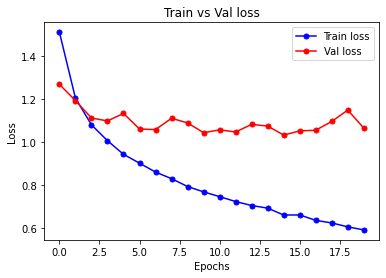

Best epoch: 14


In [ ]:
cnnbase_trainer = CNN_Trainer(device, CNN_base, 'CNN_base', lr=0.001)
base_best_epoch, base_losses, base_errors = cnnbase_trainer.train()
plot_train(base_losses, base_errors)
print('Best epoch:',base_best_epoch)

From the graph we can see that after 6th epoch the train loss decreases but validation loss starts increasing. It means at this point the model starts to overfit the train data and is not able to generalize well

In [ ]:
base_acc = test_model(device, CNN_base, 'q1_ckpt_CNN_base_best', test_dataset)
print('Test accuracy:',base_acc,'%')

CNN_base(
  (convLayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (denseLayers): Sequential(
    (0): Linear(in_features=16384, out_features=10, bias=True)
  )
)
Test accuracy: 65.96 %


# A) Without BatchNorm
--> 1 block of : Conv2D -> MaxPooling2D  
--> 1 dense layer  
--> ReLU activations

In [ ]:
class CNN_a(nn.Module):
    def __init__(self):
        super(CNN_a, self).__init__()
        self.convLayers = nn.Sequential(
            # block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 16x16x64 = 16384
        )
        self.denseLayers = nn.Sequential(
            nn.Linear(16384, 10)
        )

    def forward(self,x):
        x = self.convLayers(x)
        x = torch.flatten(x, start_dim=1)
        # print('after conv',x.shape)
        x = self.denseLayers(x)
        return x

cuda Tesla T4
Epoch:0   Loss:1.785   Val error:1.613   Best val error:1.613
Epoch:1   Loss:1.549   Val error:1.479   Best val error:1.479
Epoch:2   Loss:1.425   Val error:1.4   Best val error:1.4
Epoch:3   Loss:1.344   Val error:1.333   Best val error:1.333
Epoch:4   Loss:1.287   Val error:1.291   Best val error:1.291
Epoch:5   Loss:1.245   Val error:1.266   Best val error:1.266
Epoch:6   Loss:1.209   Val error:1.229   Best val error:1.229
Epoch:7   Loss:1.183   Val error:1.211   Best val error:1.211
Epoch:8   Loss:1.156   Val error:1.194   Best val error:1.194
Epoch:9   Loss:1.133   Val error:1.185   Best val error:1.185
Epoch:10   Loss:1.115   Val error:1.163   Best val error:1.163
Epoch:11   Loss:1.097   Val error:1.155   Best val error:1.155
Epoch:12   Loss:1.079   Val error:1.138   Best val error:1.138
Epoch:13   Loss:1.062   Val error:1.128   Best val error:1.128
Epoch:14   Loss:1.045   Val error:1.126   Best val error:1.126
Epoch:15   Loss:1.03   Val error:1.111   Best val error

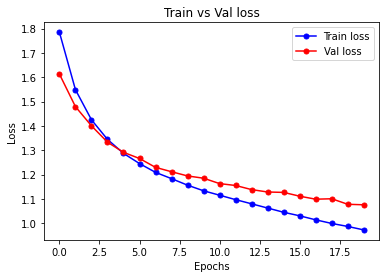

Best epoch: 19


In [ ]:
cnna_trainer = CNN_Trainer(device, CNN_a, 'CNN_a', lr=0.001)
a_best_epoch, a_losses, a_errors = cnna_trainer.train()
plot_train(a_losses, a_errors)
print('Best epoch:',a_best_epoch)

In [ ]:
a_acc = test_model(device, CNN_a, 'q1_ckpt_CNN_a_best', test_dataset)
print('Test accuracy:',a_acc,'%')

CNN_a(
  (convLayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (denseLayers): Sequential(
    (0): Linear(in_features=16384, out_features=10, bias=True)
  )
)
Test accuracy: 62.7 %


We can see that both train and validation loss are higher than the ones using batch-normalization. This is because of the presence of internal covariate shift (input ot the model is slightly different every time as batches are random samples of train dataset).  
The benefits of batch-normalization are:  
--> It ensures that the inputs have a mean of 0 and a standard deviation of 1, meaning that the input distribution to every neuron will be the same, thereby fixing the problem of internal covariate shift and providing regularisation.  
--> It prevents vanishing and exploding gradients by ensuring that no weight has gone too high or low.  
--> It has a regularising effect since it adds noise to the inputs of every layer thus discouraging overfitting.


# B) 2 dense layers  
--> 1 block of : Conv2D -> BatchNorm2D -> MaxPooling2D  
--> 2 dense layers  
--> ReLU activations  
--> Learning rate decay (if val loss increases)

In [ ]:
class CNN_b(nn.Module):
    def __init__(self):
        super(CNN_b, self).__init__()
        self.convLayers = nn.Sequential(
            # block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) #16384
        )
        self.denseLayers = nn.Sequential(
            nn.Linear(16384, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10),
        )

    def forward(self,x):
        x = self.convLayers(x)
        x = torch.flatten(x, start_dim=1)
        # print('after conv',x.shape)
        x = self.denseLayers(x)
        return x

cuda Tesla T4
Epoch:0   Loss:1.58   Val error:1.354   Best val error:1.354
Epoch:1   Loss:1.258   Val error:1.217   Best val error:1.217
Epoch:2   Loss:1.117   Val error:1.136   Best val error:1.136
Epoch:3   Loss:1.027   Val error:1.046   Best val error:1.046
Epoch:4   Loss:0.952   Val error:1.04   Best val error:1.04
Epoch:5   Loss:0.889   Val error:1.006   Best val error:1.006
Epoch:6   Loss:0.844   Val error:1.011   Best val error:1.006
Epoch:7   Loss:0.803   Val error:0.988   Best val error:0.988
Epoch:8   Loss:0.762   Val error:1.032   Best val error:0.988
Epoch:9   Loss:0.724   Val error:0.983   Best val error:0.983
Epoch:10   Loss:0.686   Val error:0.953   Best val error:0.953
Epoch:11   Loss:0.647   Val error:0.973   Best val error:0.953
Epoch:12   Loss:0.614   Val error:0.963   Best val error:0.953
Epoch:13   Loss:0.578   Val error:1.049   Best val error:0.953
LR adjusted
Epoch:14   Loss:0.543   Val error:1.006   Best val error:0.953
LR adjusted
Epoch:15   Loss:0.506   Val er

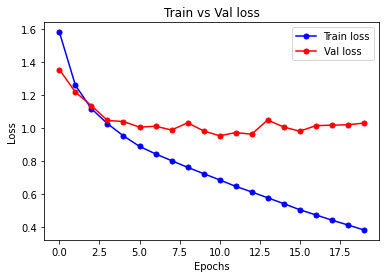

Best epoch: 10


In [ ]:
cnnb_trainer = CNN_Trainer(device, CNN_b, 'CNN_b', lr=0.001, lr_decay=0.95)
b_best_epoch, b_losses, b_errors = cnnb_trainer.train()
plot_train(b_losses, b_errors)
print('Best epoch:',b_best_epoch)

In [ ]:
b_acc = test_model(device, CNN_b, 'q1_ckpt_CNN_b_best', test_dataset)
print('Test accuracy:',b_acc,'%')

CNN_b(
  (convLayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (denseLayers): Sequential(
    (0): Linear(in_features=16384, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Test accuracy: 67.35 %


We can see that adding a dense layer increased the accuracy of the network as it is now able to learn with more weights

# C) 2 blocks of : Conv2D -> BatchNorm2D-> MaxPooling2D  
--> 2 blocks of : Conv2D -> BatchNorm2D -> MaxPooling2D  
--> 2 dense layers  
--> ReLU activations  
--> Dropout  
--> Learning rate decay (if val loss increases)  
--> Regularization (weight decay)

In [ ]:
class CNN_c(nn.Module):
    def __init__(self):
        super(CNN_c, self).__init__()
        self.convLayers = nn.Sequential(
            # block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2) # 8x8x64
        )
        self.denseLayers = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),
        )

    def forward(self,x):
        x = self.convLayers(x)
        x = torch.flatten(x, start_dim=1)
        # print('after conv',x.shape)
        x = self.denseLayers(x)
        return x

cuda Tesla T4
Epoch:0   Loss:1.575   Val error:1.341   Best val error:1.341
Epoch:1   Loss:1.208   Val error:1.17   Best val error:1.17
Epoch:2   Loss:1.066   Val error:1.074   Best val error:1.074
Epoch:3   Loss:0.986   Val error:0.997   Best val error:0.997
Epoch:4   Loss:0.928   Val error:0.971   Best val error:0.971
Epoch:5   Loss:0.882   Val error:0.945   Best val error:0.945
Epoch:6   Loss:0.846   Val error:0.89   Best val error:0.89
Epoch:7   Loss:0.801   Val error:0.864   Best val error:0.864
Epoch:8   Loss:0.77   Val error:0.842   Best val error:0.842
Epoch:9   Loss:0.737   Val error:0.817   Best val error:0.817
Epoch:10   Loss:0.705   Val error:0.816   Best val error:0.816
Epoch:11   Loss:0.678   Val error:0.822   Best val error:0.816
Epoch:12   Loss:0.646   Val error:0.792   Best val error:0.792
Epoch:13   Loss:0.619   Val error:0.79   Best val error:0.79
Epoch:14   Loss:0.595   Val error:0.749   Best val error:0.749
Epoch:15   Loss:0.569   Val error:0.742   Best val error:0

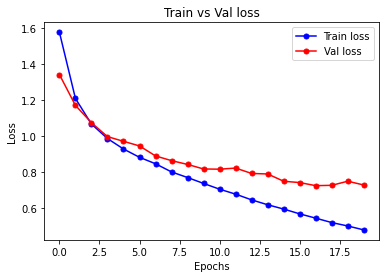

Best epoch: 16


In [ ]:
cnnc_trainer = CNN_Trainer(device, CNN_c, 'CNN_c', lr=0.001, lr_decay=0.95, weight_decay=1e-4)
c_best_epoch, c_losses, c_errors = cnnc_trainer.train()
plot_train(c_losses, c_errors)
print('Best epoch:',c_best_epoch)

In [ ]:
# model = CNN_a().cuda()
c_acc = test_model(device, CNN_c, 'q1_ckpt_CNN_c_best', test_dataset)
print('Test accuracy:',c_acc,'%')

CNN_c(
  (convLayers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (denseLayers): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)
Test accuracy: 74.7 %


We can see there is a large increase in the accuracy of the model after adding dropout layers. Also the train loss decreases slightly slower than before. This is because dropout randomly deactivates some neurons of a layer, thus nullifying their contribution to the output. This prevents neurons to be dependant on each other or only on specific features. This avoids overfitting the training data and hence increases the generalization power of the network.

# D) 3 blocks of : Conv2D -> BatchNorm2D-> MaxPooling2D  
--> 3 blocks of : Conv2D -> BatchNorm2D -> MaxPooling2D  
--> 2 dense layers  
--> LeakyReLU activations  
--> Dropout  
--> Learning rate decay (if val loss does not reduce)  
--> Regularization (weight decay)

In [ ]:
class CNN_d(nn.Module):
    def __init__(self):
        super(CNN_d, self).__init__()
        self.convLayers = nn.Sequential(
            # block 1
            # block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8x64

            # block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2) # 4x4x128
        )
        self.denseLayers = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(2048, 512),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Linear(512, 10),
        )

    def forward(self,x):
        x = self.convLayers(x)
        x = torch.flatten(x, start_dim=1)
        # print('after conv',x.shape)
        x = self.denseLayers(x)
        return x

cuda Tesla T4
Epoch:0   Loss:1.305   Val error:1.159   Best val error:1.159
Epoch:1   Loss:0.928   Val error:0.873   Best val error:0.873
Epoch:2   Loss:0.785   Val error:0.898   Best val error:0.873
Epoch:3   Loss:0.693   Val error:0.761   Best val error:0.761
Epoch:4   Loss:0.611   Val error:0.728   Best val error:0.728
Epoch:5   Loss:0.552   Val error:0.773   Best val error:0.728
Epoch:6   Loss:0.493   Val error:0.699   Best val error:0.699
Epoch:7   Loss:0.455   Val error:0.629   Best val error:0.629
Epoch:8   Loss:0.406   Val error:0.653   Best val error:0.629
Epoch:9   Loss:0.361   Val error:0.707   Best val error:0.629
Epoch:10   Loss:0.326   Val error:0.704   Best val error:0.629
LR adjusted
Epoch:11   Loss:0.289   Val error:0.615   Best val error:0.615
Epoch:12   Loss:0.261   Val error:0.608   Best val error:0.608
Epoch:13   Loss:0.237   Val error:0.655   Best val error:0.608
Epoch:14   Loss:0.213   Val error:0.647   Best val error:0.608
Epoch:15   Loss:0.186   Val error:0.634

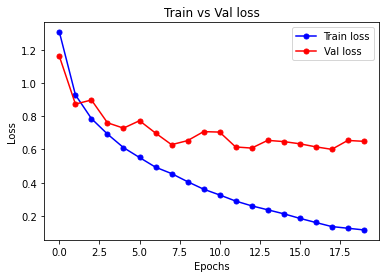

Best epoch: 17


In [ ]:
cnnd_trainer = CNN_Trainer(device, CNN_d, 'CNN_d', lr=0.01, epochs=20, lr_decay=0.95, weight_decay=1e-4)
d_best_epoch, d_losses, d_errors = cnnd_trainer.train()
plot_train(d_losses, d_errors)
print('Best epoch:',d_best_epoch)

In [ ]:
d_acc = test_model(device, CNN_d, 'q1_ckpt_CNN_d_best', test_dataset)
print('Test accuracy:',d_acc,'%')

CNN_d(
  (convLayers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.1, inplace=True)
    (13): Dropout(p=0.1, inplace=False)
    (14): MaxPool2d(kern

We can see that adding a convolutional block increased the accuracy of the network as it is now able to learn with more weights. Also regularization (weight decay) discourages learning a more complex or flexible model, so as to avoid the risk of overfitting.

# E) Random horizontal flipping of images & model weights initialization using Xavier's Normal
--> 3 blocks of : Conv2D -> BatchNorm2D -> MaxPooling2D  
--> 1 dense layer  
--> LeakyReLU activations  
--> Dropout  
--> Learning rate decay (if val loss increases)  
--> Regularization (weight decay)  
--> Model weights initialization using Xavier's Normal  
--> Random horizontal flipping of images

In [ ]:
class CNN_e(nn.Module):
    def __init__(self):
        super(CNN_e, self).__init__()
        self.convLayers = nn.Sequential(
            # block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2) # 4x4x128
        )
        self.denseLayers = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(2048, 512),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Linear(512, 10),
        )
        self._initialize_weights()

    def forward(self,x):
        x = self.convLayers(x)
        x = torch.flatten(x, start_dim=1)
        # print('after conv',x.shape)
        x = self.denseLayers(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [ ]:
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
os.makedirs("data/cifar", exist_ok=True)
train_dataset2 = CIFAR10(root='data/cifar', download=True, transform=transform2)
test_dataset2 = CIFAR10(root='data/cifar', train=False, transform=transform2)
print(len(train_dataset2), len(test_dataset2))

Files already downloaded and verified
50000 10000


cuda Tesla T4
Epoch:0   Loss:1.367   Val error:1.153   Best val error:1.153
Epoch:1   Loss:0.997   Val error:0.968   Best val error:0.968
Epoch:2   Loss:0.847   Val error:0.869   Best val error:0.869
Epoch:3   Loss:0.757   Val error:0.822   Best val error:0.822
Epoch:4   Loss:0.703   Val error:0.883   Best val error:0.822
Epoch:5   Loss:0.641   Val error:0.728   Best val error:0.728
Epoch:6   Loss:0.608   Val error:0.662   Best val error:0.662
Epoch:7   Loss:0.562   Val error:0.639   Best val error:0.639
Epoch:8   Loss:0.533   Val error:0.625   Best val error:0.625
Epoch:9   Loss:0.499   Val error:0.645   Best val error:0.625
Epoch:10   Loss:0.48   Val error:0.605   Best val error:0.605
Epoch:11   Loss:0.454   Val error:0.577   Best val error:0.577
Epoch:12   Loss:0.427   Val error:0.593   Best val error:0.577
Epoch:13   Loss:0.411   Val error:0.643   Best val error:0.577
Epoch:14   Loss:0.394   Val error:0.558   Best val error:0.558
Epoch:15   Loss:0.372   Val error:0.562   Best val e

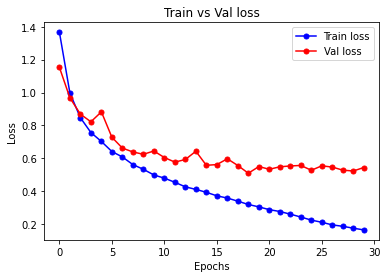

Best epoch: 18


In [ ]:
cnne_trainer = CNN_Trainer(device, CNN_e, 'CNN_e', lr=0.01,  epochs=30, lr_decay=0.95, weight_decay=1e-4, trainset=train_dataset2, valset=test_dataset2)
e_best_epoch, e_losses, e_errors = cnne_trainer.train()
plot_train(e_losses, e_errors)
print('Best epoch:',e_best_epoch)

In [ ]:
e_acc = test_model(device, CNN_e, 'q1_ckpt_CNN_e_best', test_dataset2)
print('Test accuracy:',e_acc,'%')

CNN_e(
  (convLayers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.1, inplace=True)
    (13): Dropout(p=0.1, inplace=False)
    (14): MaxPool2d(kern

We can see there is a significant increase in the accuracy after data augmentation (random horizontal flipping). As data-augmentation increases the variations in the training data, it also takes some more time for the model to train but it improves the performance and ability of the model to generalize. Also weight initialization method serves as a good starting point for initialization and mitigates the chances of exploding or vanishing gradients.

### Comparison of accuracies of models : D > C > B > Baseline > A  
Details about variations used in the networks are mentioned above

In [ ]:
print('D: 3 Conv blocks: ',d_acc)
print('C: 2 Conv blocks: ',c_acc)
print('B: 2 dense layers: ',b_acc)
print('Baseline: ',base_acc)
print('A: No batchnorm: ',a_acc)

D: 3 Conv blocks:  81.6
C: 2 Conv blocks:  74.7
B: 2 dense layers:  67.35
Baseline:  65.96
A: No batchnorm:  62.7
